# 로스만 데이터 불러오기

In [4]:
import pandas as pd

In [5]:
## 데이터를 불러옵니다.
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/rossmann/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/rossmann/test.csv")
store = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/rossmann/store.csv")


train 데이터와 store 데이터를 활용하여 test 데이터의 Sales 수를 예측해보자

In [6]:
train.head()

,id,Store,Date,Sales,Promo,StateHoliday,SchoolHoliday
0,14929,85,2015-05-01,11360,1,a,0
1,14930,512,2015-05-01,10534,1,a,0
2,14931,1097,2015-05-01,17039,1,a,0
3,14932,1,2015-04-30,6228,1,0,0
4,14933,9,2015-04-30,9717,1,0,0


In [ ]:
test.head()

In [ ]:
store.head()

### 변수 설명



*   id : 상점의 id
*   Store : 상점의 고유번호
*   Date : 상점의 오픈 날짜
*   Sales : 상품의 판매량 ( Target 값 )
*   Promo : 프로모션의 진행 여부 
*   Stateholiday : 주의 휴무여부
*   SchoolHoliday : 학교의 휴무여부



# StateHoliday 변수 변환

범주화 변수들을 get_dummies를 통해 수치화 진행

In [11]:
train = pd.get_dummies(columns=['StateHoliday'],data=train)
test = pd.get_dummies(columns=['StateHoliday'],data=test)

In [12]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,14929,85,2015-05-01,11360,1,0,0,1,0,0
1,14930,512,2015-05-01,10534,1,0,0,1,0,0
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0
3,14932,1,2015-04-30,6228,1,0,1,0,0,0
4,14933,9,2015-04-30,9717,1,0,1,0,0,0


In [13]:
test.head()

,id,Store,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a
0,0,1,2015-07-01,1,0,1,0
1,1,9,2015-07-01,1,1,1,0
2,2,11,2015-07-01,1,0,1,0
3,3,12,2015-07-01,1,0,1,0
4,4,14,2015-07-01,1,1,1,0


test 데이터에는 StateHoliday가 b, c 인 경우는 없음
따라서 test 데이터 셋에도 b, c 칼럼을 따로 생성

In [14]:
test['StateHoliday_b'] = 0
test['StateHoliday_c'] = 0

#  Date 변수를 활용한 FE

Date 컬럼을 날짜형식으로 변환 후 년도, 월, 요일 별로 컬럼을 생성

In [15]:
train['Date'] = pd.to_datetime( train['Date'] )
test['Date'] = pd.to_datetime( test['Date'] )

In [18]:
train['weekday'] = train['Date'].dt.weekday
test['weekday'] = test['Date'].dt.weekday

In [17]:
train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

In [16]:
train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

In [19]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,month,year,weekday
0,14929,85,2015-05-01,11360,1,0,0,1,0,0,5,2015,4
1,14930,512,2015-05-01,10534,1,0,0,1,0,0,5,2015,4
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0,5,2015,4
3,14932,1,2015-04-30,6228,1,0,1,0,0,0,4,2015,3
4,14933,9,2015-04-30,9717,1,0,1,0,0,0,4,2015,3


# 베이스라인 모델링

In [25]:
from xgboost import XGBRegressor

In [26]:
xgb = XGBRegressor( n_estimators= 300 , learning_rate=0.1 , random_state=2020 )
xgb.fit(train[['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']],
        train['Sales'])

[05:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:
test['Sales'] = xgb.predict(test[['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']])

In [28]:
test[['id','Sales']]

,id,Sales
0,0,9706.320312
1,1,9208.548828
2,2,9706.320312
3,3,9706.320312
4,4,9208.548828
...,...,...
14924,14924,7850.427246
14925,14925,7850.427246
14926,14926,7850.427246
14927,14927,7850.427246


In [36]:
import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks/data/rossmann')

In [37]:
test[['id','Sales']].to_csv("submission.csv",index=False)

# 변수선택

변수들의 변수 중요도를 파악하여 의미있는 변수들만을 이용

In [38]:
xgb.feature_importances_
input_var = ['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']
imp_df = pd.DataFrame({"var": input_var,
                       "imp":xgb.feature_importances_})

In [39]:
imp_df = imp_df.sort_values(['imp'],ascending=False)

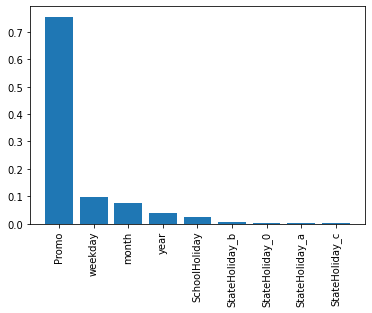

In [40]:

import matplotlib.pyplot as plt
plt.bar(imp_df['var'],imp_df['imp'])
plt.xticks(rotation=90)
plt.show()

Cross Validation을 활용하여 변수를 몇개 선택할지 결정

In [41]:
from sklearn.model_selection import cross_val_score

In [42]:
import numpy as np
score_list=[]
selected_varnum=[]

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# input 변수를 하나씩 추가하며 점수 list 생성
for i in range(1,10):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train[selected_var], 
                             train['Sales'], 
                             scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)


변수의 갯수에 따른 Score 시각화

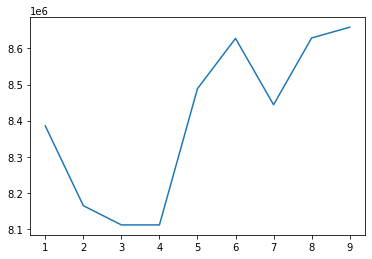

In [45]:
plt.plot(selected_varnum, score_list)

변수를 3개까지 했을때 score점수가 가장 낮은 것을 확인

In [46]:
xgb.fit(train[['Promo','weekday','month']],
        train['Sales'])
test['Sales'] = xgb.predict(test[['Promo','weekday','month']])
test[['id','Sales']].to_csv("submission1.csv",index=False)

[06:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# store 데이터 활용

In [47]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Store 컬럼을 기준으로 test,train 데이터와 병합 진행

In [48]:
train = pd.merge(train, store, on=['Store'], how='left')
test = pd.merge(test, store, on=['Store'], how='left')

주변의 경쟁업체가 언제 오픈했는지를 계산하여 CompetitionOpen 변수에 저장



*   12 x ( Year - 경정업체 Open 년도) + (Month - 경쟁업체 오픈 Month)




In [49]:
train['CompetitionOpen'] = 12*( train['year'] - train['CompetitionOpenSinceYear'] ) + \
                             (train['month'] - train['CompetitionOpenSinceMonth'])

test['CompetitionOpen'] = 12*( test['year'] - test['CompetitionOpenSinceYear'] ) + \
                             (test['month'] - test['CompetitionOpenSinceMonth'])

마찬가지의 방법으로 프로모션이 얼마나 진행되었는지를 확인하여 PromoOpen 변수에 저장



*   12 x ( Year - 프로모션시작Year) + (WeekOfYear - 프로모션시작 WeekOfYear) / 4




In [50]:
# 몇번째 주인지를 확인
train['WeekOfYear'] = train['Date'].dt.weekofyear
test['WeekOfYear'] = test['Date'].dt.weekofyear

In [51]:
train['PromoOpen'] = 12* ( train['year'] - train['Promo2SinceYear'] ) + \
                        (train['WeekOfYear'] - train['Promo2SinceWeek']) / 4

test['PromoOpen'] = 12* ( test['year'] - test['Promo2SinceYear'] ) + \
                        (test['WeekOfYear'] - test['Promo2SinceWeek']) / 4

In [52]:
## StoreType 변수를 one hot encoding합니다.
train = pd.get_dummies(columns=['StoreType'],data=train)
test = pd.get_dummies(columns=['StoreType'],data=test)

In [53]:
## Assortment 변수를 one hot encoding합니다.
train = pd.get_dummies(columns=['Assortment'],data=train)
test = pd.get_dummies(columns=['Assortment'],data=test)

In [54]:
## PromoInterval 변수를 one hot encoding합니다.
train = pd.get_dummies(columns=['PromoInterval'],data=train)
test = pd.get_dummies(columns=['PromoInterval'],data=test)

#  2차 모델링

In [55]:
# 2차 모델링 변수 지정
input_var = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'Promo2',
       'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [56]:
xgb = XGBRegressor( n_estimators=300, learning_rate= 0.1, random_state=2020)
xgb.fit(train[input_var],train['Sales'])

[06:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

앞선 모델링과 마찬가지로 변수의 중요도를 점수화하여 몇개의 변수를 사용할지 결정

In [57]:
imp_df = pd.DataFrame({'var':input_var,
                       'imp':xgb.feature_importances_})
imp_df = imp_df.sort_values(['imp'],ascending=False)

In [58]:
score_list=[]
selected_varnum=[]

In [ ]:
for i in range(1,25):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train[selected_var], 
                             train['Sales'], 
                             scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)

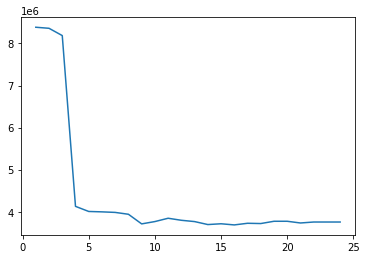

In [60]:
plt.plot(selected_varnum, score_list)

15 개의 변수를 활용했을때 최적의 결과가 나온다고 확인

In [61]:
input_var = imp_df['var'].iloc[:15].tolist()
xgb.fit(train[input_var],
        train['Sales'])

test['Sales'] = xgb.predict(test[input_var])

test[['id','Sales']].to_csv("submission2.csv",index=False)

[06:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# 파라미터 튜닝

XGB 의 최적의 n_estimators 를 찾는 작업 진행

In [63]:

estim_list = [100,200,300,400,500,600,700,800,900]
score_list = []

In [64]:
for i in estim_list:
    xgb = XGBRegressor( n_estimators=i, learning_rate= 0.1, random_state=2020)
    scores = cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    print(i)

[06:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100
[06:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
200
[06:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fav

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]), <a list of 11 Text major ticklabel objects>)

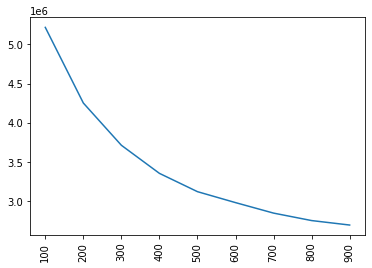

In [65]:
plt.plot(estim_list,score_list)
plt.xticks(rotation=90)

In [66]:
xgb = XGBRegressor( n_estimators=900, learning_rate= 0.1, random_state=2020)

In [67]:
xgb.fit(train[input_var],
        train['Sales'])

test['Sales'] = xgb.predict(test[input_var])

test[['id','Sales']].to_csv("submission3.csv",index=False)

[06:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
